# Assignment 4: MIMICIII - Classification Performance 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
data = pd.read_csv("mimic_clean.csv", index_col=0)
data.head()

,bicarbonate,bun,chloride,creatinine,dbp,glucose,heart_rate,hematocrit,hemoglobin,map,...,resp_rate,sodium,sbp,temp,wbc,age,gender,ethnicity,los,death_status
0,23.0,17.0,96.0,1.3,55.545455,85.0,92.904762,29.6,9.7,75.984845,...,20.363636,131.500000,116.863636,35.930556,10.5,76.0,M,White,6.0646,0
1,14.0,73.0,101.0,5.1,64.047619,118.0,85.750000,35.7,12.2,93.873014,...,14.347826,130.000000,153.523810,36.039682,3.9,66.0,F,White,3.6729,0
2,24.0,33.0,107.0,2.0,76.476190,114.0,81.904762,36.8,12.6,94.850000,...,16.653846,135.666667,141.666667,35.888889,11.1,41.0,M,Other,5.3231,1
3,23.0,29.0,100.0,1.1,75.450000,130.0,94.650000,36.6,12.4,99.066730,...,31.400000,135.000000,146.300000,37.074074,30.2,72.0,M,White,7.6348,1
4,29.0,13.0,104.0,0.4,60.520000,168.5,99.600000,26.9,8.8,78.533332,...,18.840000,138.000000,125.440000,37.687301,14.3,40.0,F,White,3.6660,0


Before we begin our analysis, we first split our data into features and target.

### Categorical Variables

We then determine if any of the patients' demographics are associated with hospital survival. To accomplish this, we carry out a chi-squared test.

- Null Hypothesis (H0): Gender and ethnicity are independent of the target class.
- Alternative Hypothesis (Ha): Gender and ethnicity are not independent of the target class.

In [3]:
X = data.drop(columns='death_status')
y = data['death_status']

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2

label_encoder = LabelEncoder()

X_cat = X[['gender', 'ethnicity']].copy()
X_cat['ethnicity'] = label_encoder.fit_transform(X_cat['ethnicity'])
X_cat['gender'] = label_encoder.fit_transform(X_cat['gender'])

chi_scores, p_values = chi2(X_cat, y)

chi2_df = pd.DataFrame({
    'feature': X_cat.columns,
    'X2 statistic': chi_scores,
    'p-value': p_values
})

chi2_df

,feature,X2 statistic,p-value
0,gender,3.376465,0.066134
1,ethnicity,0.153405,0.695302


As the p-values for both gender and ethnicity are greater than the 5% significance level, we fail to reject our H0. We conclude that patients' demographics are independent of hospital survival status. Thus, we drop these columns from our dataset

In [5]:
X = X.drop(columns=['gender', 'ethnicity'])
X.head()

,bicarbonate,bun,chloride,creatinine,dbp,glucose,heart_rate,hematocrit,hemoglobin,map,spo2,platelets,potassium,resp_rate,sodium,sbp,temp,wbc,age,los
0,23.0,17.0,96.0,1.3,55.545455,85.0,92.904762,29.6,9.7,75.984845,96.545455,191.0,3.40,20.363636,131.500000,116.863636,35.930556,10.5,76.0,6.0646
1,14.0,73.0,101.0,5.1,64.047619,118.0,85.750000,35.7,12.2,93.873014,97.000000,160.0,4.70,14.347826,130.000000,153.523810,36.039682,3.9,66.0,3.6729
2,24.0,33.0,107.0,2.0,76.476190,114.0,81.904762,36.8,12.6,94.850000,99.666667,330.0,3.50,16.653846,135.666667,141.666667,35.888889,11.1,41.0,5.3231
3,23.0,29.0,100.0,1.1,75.450000,130.0,94.650000,36.6,12.4,99.066730,97.200000,279.0,3.80,31.400000,135.000000,146.300000,37.074074,30.2,72.0,7.6348
4,29.0,13.0,104.0,0.4,60.520000,168.5,99.600000,26.9,8.8,78.533332,99.280000,103.0,4.25,18.840000,138.000000,125.440000,37.687301,14.3,40.0,3.6660


We observe that the units of measurement for our vital signs and laboratory measurements are all different. Therefore, we need to scale our data so that each feature is on a comparable scale and contributes equally to the analysis. Scaling ensures that features with larger ranges do not disproportionately influence the model or dominate those with smaller ranges.

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled.head()


,bicarbonate,bun,chloride,creatinine,dbp,glucose,heart_rate,hematocrit,hemoglobin,map,spo2,platelets,potassium,resp_rate,sodium,sbp,temp,wbc,age,los
0,-0.676010,-0.453178,-1.476126,0.018950,-0.435400,-0.963251,0.573509,-0.166019,-0.347339,-0.255940,0.131105,-0.306721,-1.257552,0.059072,-1.628294,-0.300400,-1.273335,-0.108709,0.639284,-0.103233
1,-2.655866,2.168225,-0.561497,2.941633,0.290500,-0.180128,0.076088,1.215348,1.267272,1.183369,0.260832,-0.516443,1.452639,-1.370871,-1.961778,1.637261,-1.115559,-1.199852,0.052806,-0.421558
2,-0.456026,0.295794,0.536057,0.557339,1.351630,-0.275052,-0.191244,1.464447,1.525610,1.261979,1.021891,0.633648,-1.049075,-0.822736,-0.701950,1.010555,-1.333578,-0.009515,-1.413387,-0.201923
3,-0.676010,0.108551,-0.744423,-0.134876,1.264016,0.104644,0.694843,1.419156,1.396441,1.601264,0.317911,0.288621,-0.423647,2.682388,-0.850165,1.255449,0.379982,3.148187,0.404693,0.105754
4,0.643893,-0.640421,-0.012720,-0.673265,-0.010682,1.018288,1.038982,-0.777444,-0.928599,-0.050885,0.911538,-0.902062,0.514496,-0.303093,-0.183198,0.152901,1.266595,0.519524,-1.472035,-0.422476


### Target variable

death_status
0    0.863185
1    0.136815
Name: proportion, dtype: float64

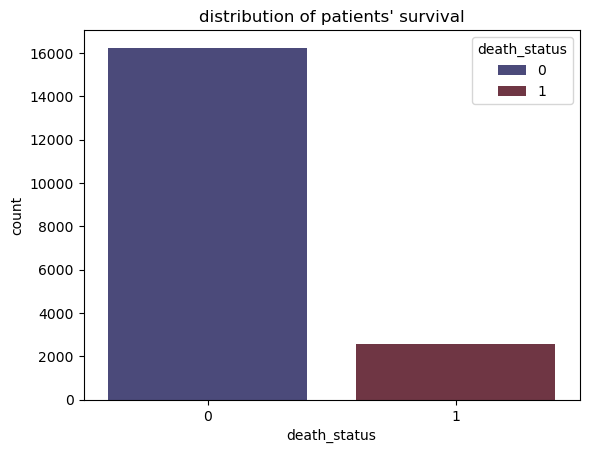

In [7]:
sns.countplot(x=y, hue=y, palette='icefire')
plt.title("distribution of patients' survival")

data['death_status'].value_counts(normalize=True)

When we look at the distribution of the target class, we see that it is imbalanced. It is made up of 86.3% of patients who survived the ICU and 13.7% who did not, which means there are about six times as many survivors as non-survivors.

We need to account for this class imbalance to ensure that our model does not become biased towards the majority class. There are many methods to address this class imbalance, such as oversampling the minority class or undersampling the majority class. Undersampling the majority class can result in a loss of information, while oversampling the minority class can introduce noise. Therefore, we use a hybrid method going forward, which combines both oversampling and undersampling techniques to balance the dataset more effectively.

### Train/Test split

Before we begin developing our model for ICU survival prediction, we first split our dataset into training and testing sets using a 70/30 ratio.

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

### Linear Optimal Low-rank Projection & Imbalance Classification

As we have over 20 features in our final model, it could become computationally expensive and prone to overfitting due to the high dimensionality of the data. To address this, we implement a dimension reduction technique known as Linear Optimal Low-rank projection (LOL). LOL is designed to project high-dimensional data into a lower-dimensional space by preserving the most significant information, reducing noise, and enhancing computational efficiency. This technique leverages label information to optimize the projection, making it particularly effective.

We first create a baseline model without handling the class imbalance. We initialize the LOL model with all components and use it to transform the training and test data. We then train a Logistic Regression on the transformed training data to evaluate its classification performance on the test data. The baseline report without handling imbalance is printed for reference.

In [9]:
from lol import LOL
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize Lollipop with an arbitrary number of components for baseline
lmao = LOL()

# Fit the Lollipop model on the training data
X_train_lol = lmao.fit_transform(X_train, y_train)

# Transform the test data
X_test_lollipop = lmao.transform(X_test)

# Initialize and train the logistic regression model
baseline_model = LogisticRegression()
baseline_model.fit(X_train_lol, y_train)

# Predict on the test data
y_pred_baseline = baseline_model.predict(X_test_lollipop)

# Calculate and print the accuracy for the baseline model
class_report = classification_report(y_test, y_pred_baseline)

print(class_report)

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      4896
           1       0.85      0.45      0.59       751

    accuracy                           0.92      5647
   macro avg       0.88      0.72      0.77      5647
weighted avg       0.91      0.92      0.90      5647



The baseline model achieves a precision of 92%, a recall of 45%, and an overall accuracy of 92%. The high accuracy is primarily due to the model's effectiveness in identifying patients who survived the ICU stay (class 0). However, it is misleading as it struggles to correctly classify patients who did not survive (class 1), which is evident from the low recall. Recall, which indicates the proportion of actual positives accurately identified, is vital in this context since it is essential to accurately detect high-risk patients. Therefore, improving recall is a key objective to ensure that no high-risk patients are missed.

We then determine the optimal number of components for the Lollipop model by performing cross-validation. We iterate over a range of total number of components and record the cross-validation scores.

Using the optimal number of components, we transform the resampled training data and the test data with LOL. We then train Logistic Regression on the transformed, balanced training data and evaluate its report on the test data. We then compare the results to the baseline model.

In [10]:
from imblearn.combine import SMOTEENN
from sklearn.model_selection import cross_val_score

# Handle imbalanced classification with hybrid sampling (SMOTEENN)
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Determine optimal number of components for LOL
num_components = list(range(1, X_train.shape[1] + 1))
cv_scores = []

for n in num_components:
    lmao = LOL(n_components=n)
    X_train_lol2 = lmao.fit_transform(X_train, y_train)
    model = LogisticRegression()
    scores = cross_val_score(model, X_train_lol2, y_train, cv=5)
    cv_scores.append(scores.mean())

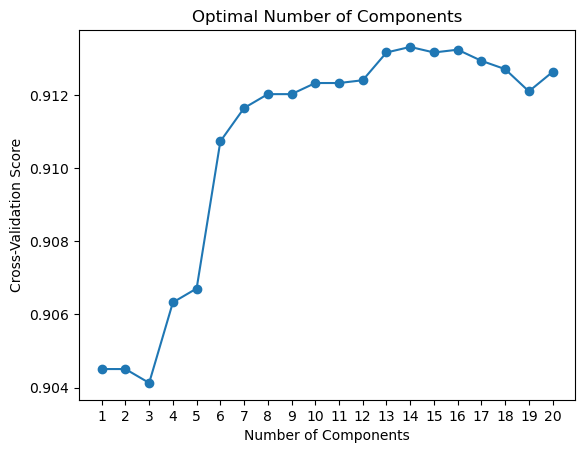

In [11]:
# Create a DataFrame to store the results
cv_results = pd.DataFrame({'Number of Components': num_components, 'Cross-Validation Score': cv_scores})

# Plot the results
plt.plot(cv_results['Number of Components'], cv_results['Cross-Validation Score'], marker='o')
plt.xlabel('Number of Components')
plt.xticks(num_components)
plt.ylabel('Cross-Validation Score')
plt.title('Optimal Number of Components')
plt.show()

From the cross-validation results, we assume that the optimal number of components is 8. As the number of components increases beyond 8, the score does not improve significantly.

We then apply LOL with 8 components, along with resampling techniques to address class imbalance, to enhance model performance.

In [12]:
# Apply LOL with the optimal number of components
lmao = LOL(n_components=8)
X_train_lol3 = lmao.fit_transform(X_train_resampled, y_train_resampled)
X_test_lol3 = lmao.transform(X_test)

# Train the Random Forest model on the transformed data
model = LogisticRegression(random_state=42)
model.fit(X_train_lol3, y_train_resampled)

# Predict on the test data
y_pred = model.predict(X_test_lol3)

# Calculate and print the accuracy with LOL and handling imbalance
accuracy = classification_report(y_test, y_pred)
print(accuracy)

              precision    recall  f1-score   support

           0       0.96      0.72      0.82      4896
           1       0.30      0.78      0.43       751

    accuracy                           0.73      5647
   macro avg       0.63      0.75      0.63      5647
weighted avg       0.87      0.73      0.77      5647



Hybrid sampling of the imbalanced data, combined with the 8-component LOL and logistic regression, resulted in a precision of 96%, recall of 78%, and an accuracy of 73%. Although the accuracy decreased, the increase in precision and recall indicates a better capture of true positives, thus effectively identifying more high-risk patients.

### PCA

Next, we carry out Principal Component Analysis (PCA) to compare its performance with that of LOL.

Additionally, we run a baseline model with logistic regression to compare its performance on the imbalanced data.

In [13]:
from sklearn.decomposition import PCA

# Baseline model without handling imbalance using PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

baseline_model = LogisticRegression()
baseline_model.fit(X_train_pca, y_train)
y_pred_baseline = baseline_model.predict(X_test_pca)
baseline_report = classification_report(y_test, y_pred_baseline)

print(baseline_report)

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      4896
           1       0.84      0.44      0.58       751

    accuracy                           0.91      5647
   macro avg       0.88      0.72      0.77      5647
weighted avg       0.91      0.91      0.90      5647



The logistic regression model achieves a precision of 92%, a recall of 44%, and an accuracy of 91%. Similar to the LOL-based model, it fails to adequately capture high-risk patients due to its lower recall.

Next, we re-perform hybrid sampling and cross-validation to determine the optimal number of components.

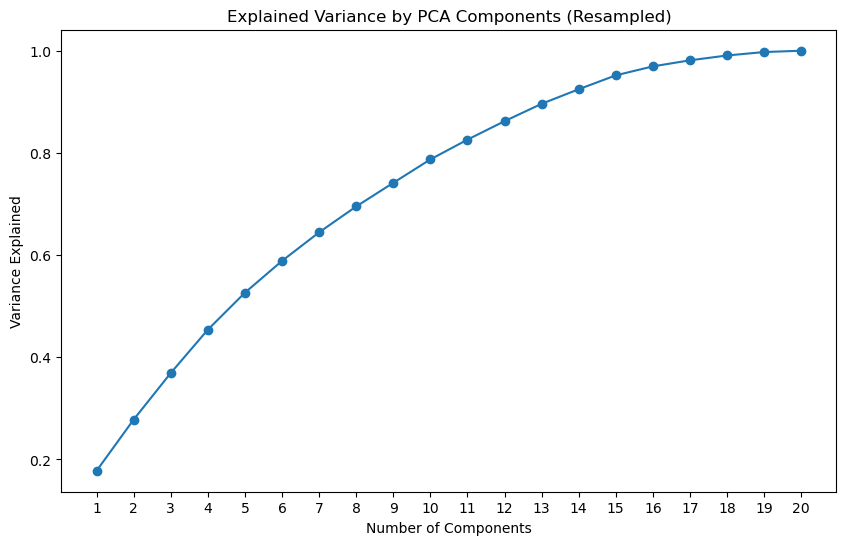

array([0.17789752, 0.2781577 , 0.36925497, 0.45404461, 0.5264298 ,
       0.58862349, 0.6445376 , 0.6951356 , 0.7414167 , 0.78725469,
       0.82593679, 0.86206899, 0.8960931 , 0.92456328, 0.9518031 ,
       0.96934837, 0.98121132, 0.99068092, 0.99740279, 1.        ])

In [14]:
# Apply PCA on resampled data
pca_resampled = PCA()
X_train_pca_resampled = pca_resampled.fit_transform(X_train_resampled)
X_test_pca_resampled = pca_resampled.transform(X_test)

# Explained variance and scree plot for resampled data
cumulative_variance_resampled = pca_resampled.explained_variance_ratio_.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_resampled) + 1), cumulative_variance_resampled, marker='o', label='Cumulative explained variance')
plt.xlabel('Number of Components')
plt.xticks(num_components)
plt.ylabel('Variance Explained')
plt.title('Explained Variance by PCA Components (Resampled)')
plt.show()

cumulative_variance_resampled

Using PCA, we found that 11 components explain 80% of the original variance present within the data. Therefore, we retain these 11 components going forward to fit our model.

In [15]:
# Apply PCA on resampled data
pca_resampled = PCA(n_components=11)
X_train_pca_resampled = pca_resampled.fit_transform(X_train_resampled)
X_test_pca_resampled = pca_resampled.transform(X_test)

# Train and evaluate logistic regression model on resampled data
model_resampled = LogisticRegression()
model_resampled.fit(X_train_pca_resampled, y_train_resampled)
y_pred_resampled = model_resampled.predict(X_test_pca_resampled)
resampled_report = classification_report(y_test, y_pred_resampled)
print(resampled_report)

              precision    recall  f1-score   support

           0       0.95      0.72      0.82      4896
           1       0.29      0.77      0.43       751

    accuracy                           0.72      5647
   macro avg       0.62      0.74      0.62      5647
weighted avg       0.87      0.72      0.77      5647



Logistic regression on the PCA-transformed data with 11 components resulted in a precision of 95%, a recall of 77%, and an accuracy of 72%. Similar to the LOL-based model, the accuracy decreased, but both precision and recall increased, capturing a more accurate scenario by identifying more high-risk patients.

The precision, recall, and accuracy of LOL-based model is all slightly higher than that of PCA-transformed data.

### LOL vs PCA

We next compare the classification error of LOL and PCA-based logistic regression models.

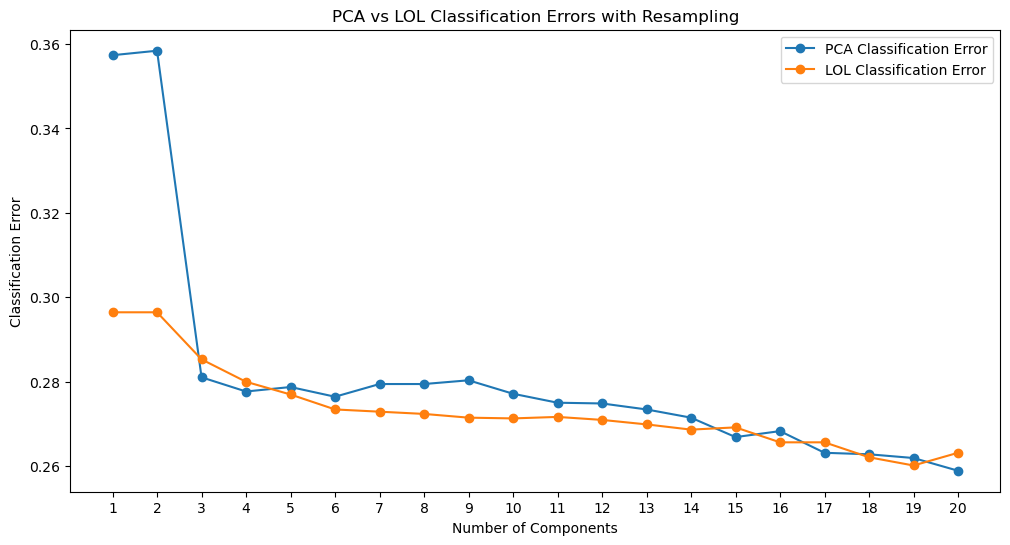

In [16]:
from sklearn.metrics import accuracy_score

# Determine classification errors for PCA
num_components = list(range(1, X_train.shape[1] + 1))
pca_errors = []
lol_errors = []

for n in num_components:
    # PCA
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train_resampled)
    X_test_pca = pca.transform(X_test)
    
    model_pca = LogisticRegression(random_state=42)
    model_pca.fit(X_train_pca, y_train_resampled)
    y_pred_pca = model_pca.predict(X_test_pca)
    pca_errors.append(1 - accuracy_score(y_test, y_pred_pca))
    
    # LOL
    lol = LOL(n_components=n)
    X_train_lol = lol.fit_transform(X_train_resampled, y_train_resampled)
    X_test_lol = lol.transform(X_test)
    
    model_lol = LogisticRegression(random_state=42)
    model_lol.fit(X_train_lol, y_train_resampled)
    y_pred_lol = model_lol.predict(X_test_lol)
    lol_errors.append(1 - accuracy_score(y_test, y_pred_lol))

# Plot classification errors
plt.figure(figsize=(12, 6))
plt.plot(num_components, pca_errors, marker='o', label='PCA Classification Error')
plt.plot(num_components, lol_errors, marker='o', label='LOL Classification Error')
plt.xlabel('Number of Components')
plt.xticks(num_components)  # Set x-ticks to match the number of components
plt.ylabel('Classification Error')
plt.title('PCA vs LOL Classification Errors with Resampling')
plt.legend()
plt.show()

The comparison graph illustrates the classification errors for both PCA and LOL models as the number of components increases.

LOL consistently maintains a slightly lower classification error compared to PCA across most component counts, highlighting its effectiveness in reducing dimensionality while preserving important information.

These results suggest that while PCA is effective, LOL can achieve similar or better performance with fewer components, making it a more efficient choice for this dataset.